# Inverse problem for the diffusion equation
## DeepXDE demo:
https://github.com/lululxvi/deepxde/blob/master/examples/pinn_inverse/diffusion_1d_inverse.py

In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import tensorflow as tf
import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Problem setup
We will solve an inverse problem for the diffusion equation with an unknown parameter 
:

 
 
with the initial condition

and the Dirichlet boundary condition

The reference solution is 
.

## We begin by defining computational geometries
We can use a built-in class Interval and TimeDomain and we combine both the domains using GeometryXTime as follows

In [5]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

## Express the PDE residual of the diffusion equation:
- The first argument to pde is 2-dimensional vector where the first component(x[:,0:1]) is 
x-coordinate and the second component (x[:,1:]) is the 
t-coordinate. 
- The second argument is the network output, i.e., the solution y(x,t) 
-C is an unknown tunable parameter with initial value 2.0

In [2]:
C = dde.Variable(2.0)

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  
    return (
        dy_t
        - C * dy_xx
        + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )

## The boundary/initial conditions
- on_boundary is chosen here to use the whole boundary of the computational domain in considered as the boundary condition. 
- We include the geotime space , time geometry created above and on_boundary as the BC in the DirichletBC function of DeepXDE. 
- We also define IC which is the initial condition for the diffusion equation and we use the computational domain, initial function, and on_initial to specify the IC.

In [3]:
def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

In [6]:
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

## Generate "observation" data
In this problem, we provide extra information on some training points, and the parameter 
 C can be identified from these observations. 
 - We generate a 2-dimensional array observe_x of 10 equally-spaced input points (x,t) as the first argument to PointSetBC, where X is in [-1,1] and t = 1. 
- The second argument func(observe_x) is the corresponding exact solution. PointSetBC compares observe_x and func(observe_x), and they satisfy the Dirichlet boundary condition.

In [7]:
observe_x = np.vstack((np.linspace(-1, 1, num=10), np.full((10), 1))).T
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)

## Define the TimePDE problem as:
- num_domain=40   is the number of training residual points sampled inside the domain
- num_boundary=20   is the number of training points sampled on the boundary (the left and right endpoints of the interval). 
- num_initial=10   include 10 initial residual points for the initial conditions
- num_test=10000   points for testing the PDE residual. 
- anchors=observe_x   is the above described training points in addition to the num_domain, num_initial, and num_boundary sampled points.

In [8]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_x,
    solution=func,
    num_test=10000,
)

## Set the network
Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 32

In [9]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

## Build the Model
- choose the optimizer and learning rate
- the unknown parameter C is passed as external_trainable_variables:

In [10]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=C)

Compiling model...
'compile' took 0.559951 s



## Train the model
- 50000 iterations
- Output the value of C every 1000 iterations:

In [11]:
variable = dde.callbacks.VariableValue(C, period=1000)
losshistory, train_state = model.train(iterations=50000, callbacks=[variable])

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.38e+01, 9.33e-02, 3.37e-01, 4.67e-02]    [1.62e+01, 9.33e-02, 3.37e-01, 4.67e-02]    [7.63e-01]    
0 [2.00e+00]
1000      [4.36e-03, 1.57e-02, 4.46e-02, 1.27e-02]    [4.90e-03, 1.57e-02, 4.46e-02, 1.27e-02]    [4.03e-01]    
1000 [1.94e+00]
2000      [2.03e-03, 4.33e-03, 8.96e-03, 7.40e-03]    [4.62e-03, 4.33e-03, 8.96e-03, 7.40e-03]    [3.88e-01]    
2000 [1.67e+00]
3000      [9.26e-04, 1.16e-03, 1.43e-03, 3.59e-03]    [1.87e-03, 1.16e-03, 1.43e-03, 3.59e-03]    [2.64e-01]    
3000 [1.38e+00]
4000      [2.93e-04, 3.92e-04, 4.00e-05, 7.90e-04]    [9.83e-04, 3.92e-04, 4.00e-05, 7.90e-04]    [1.18e-01]    
4000 [1.14e+00]
5000      [1.63e-04, 1.48e-04, 4.53e-06, 1.10e-04]    [6.04e-04, 1.48e-04, 4.53e-06, 1.10e-04]    [4.12e-02]    
5000 [1.05e+00]
6000      [1.37e-04, 6.57e-05, 3.67e-06, 2.12e-05]    [3.83e-04, 6.57e-05, 3.67e-06, 2.12e-05]   

Saving loss history to /Users/imriaharoni/Library/CloudStorage/GoogleDrive-imri.aharoni@gmail.com/My Drive/Office/DSRC/Courses and Workshops/PINN_Workshop/PINN_Workshop_Code/DeppXDE/loss.dat ...
Saving training data to /Users/imriaharoni/Library/CloudStorage/GoogleDrive-imri.aharoni@gmail.com/My Drive/Office/DSRC/Courses and Workshops/PINN_Workshop/PINN_Workshop_Code/DeppXDE/train.dat ...
Saving test data to /Users/imriaharoni/Library/CloudStorage/GoogleDrive-imri.aharoni@gmail.com/My Drive/Office/DSRC/Courses and Workshops/PINN_Workshop/PINN_Workshop_Code/DeppXDE/test.dat ...


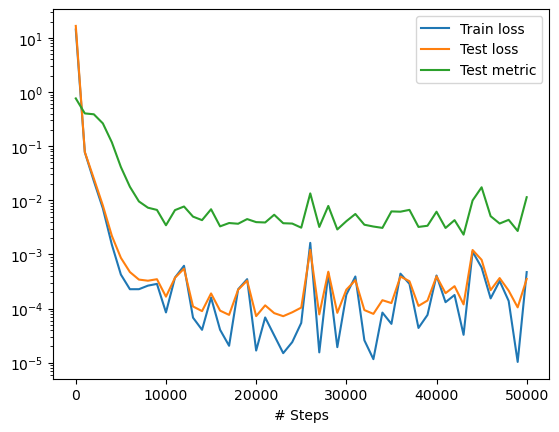

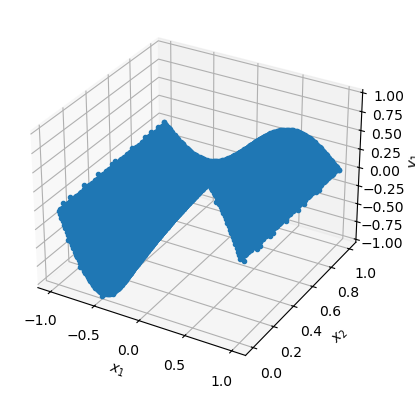

In [12]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## inverse problem of the Navier-Stokes equation of flow around cylinder
incompressible flow with Reynold number Re=100
- Code :https://github.com/lululxvi/deepxde/blob/master/examples/pinn_inverse/Navier_Stokes_inverse.py
- References: https://doi.org/10.1016/j.jcp.2018.10.045 Section 4.1.1

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle

An inverse problem of the Navier-Stokes equation of incompressible flow around cylinder with Re=100

References: https://doi.org/10.1016/j.jcp.2018.10.045 Section 4.1.1
"""

import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re



Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# true values
C1true = 1.0
C2true = 0.01

# Parameters to be identified
C1 = dde.Variable(0.0)
C2 = dde.Variable(0.0)

In [3]:
# Define Navier Stokes Equations (Time-dependent PDEs)
def Navier_Stokes_Equation(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    continuity = du_x + dv_y
    x_momentum = du_t + C1 * (u * du_x + v * du_y) + dp_x - C2 * (du_xx + du_yy)
    y_momentum = dv_t + C1 * (u * dv_x + v * dv_y) + dp_y - C2 * (dv_xx + dv_yy)
    return [continuity, x_momentum, y_momentum]

In [4]:
# Define Spatio-temporal domain
# Rectangular
Lx_min, Lx_max = 1.0, 8.0
Ly_min, Ly_max = -2.0, 2.0
# Spatial domain: X × Y = [1, 8] × [−2, 2]
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])
# Time domain: T = [0, 7]
time_domain = dde.geometry.TimeDomain(0, 7)
# Spatio-temporal domain
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


In [5]:
# Load training data
def load_training_data(num):
    data = loadmat("../Data_sets/cylinder_nektar_wake.mat")
    U_star = data["U_star"]  # N x 2 x T
    P_star = data["p_star"]  # N x T
    t_star = data["t"]  # T x 1
    X_star = data["X_star"]  # N x 2
    N = X_star.shape[0]
    T = t_star.shape[0]
    # Rearrange Data
    XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
    YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
    TT = np.tile(t_star, (1, N)).T  # N x T
    UU = U_star[:, 0, :]  # N x T
    VV = U_star[:, 1, :]  # N x T
    PP = P_star  # N x T
    x = XX.flatten()[:, None]  # NT x 1
    y = YY.flatten()[:, None]  # NT x 1
    t = TT.flatten()[:, None]  # NT x 1
    u = UU.flatten()[:, None]  # NT x 1
    v = VV.flatten()[:, None]  # NT x 1
    p = PP.flatten()[:, None]  # NT x 1
    # training domain: X × Y = [1, 8] × [−2, 2] and T = [0, 7]
    data1 = np.concatenate([x, y, t, u, v, p], 1)
    data2 = data1[:, :][data1[:, 2] <= 7]
    data3 = data2[:, :][data2[:, 0] >= 1]
    data4 = data3[:, :][data3[:, 0] <= 8]
    data5 = data4[:, :][data4[:, 1] >= -2]
    data_domain = data5[:, :][data5[:, 1] <= 2]
    # choose number of training points: num =7000
    idx = np.random.choice(data_domain.shape[0], num, replace=False)
    x_train = data_domain[idx, 0:1]
    y_train = data_domain[idx, 1:2]
    t_train = data_domain[idx, 2:3]
    u_train = data_domain[idx, 3:4]
    v_train = data_domain[idx, 4:5]
    p_train = data_domain[idx, 5:6]
    return [x_train, y_train, t_train, u_train, v_train, p_train]

# Get the training data: num = 7000
[ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=7000)
ob_xyt = np.hstack((ob_x, ob_y, ob_t))
observe_u = dde.icbc.PointSetBC(ob_xyt, ob_u, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyt, ob_v, component=1)

# Training datasets and Loss
data = dde.data.TimePDE(
    geomtime,
    Navier_Stokes_Equation,
    [observe_u, observe_v],
    num_domain=700,
    num_boundary=200,
    num_initial=100,
    anchors=ob_xyt,
)

In [6]:
# Neural Network setup
layer_size = [3] + [50] * 6 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

# callbacks for storing results
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([C1, C2], period=100, filename=fnamevar)



Compiling model...
'compile' took 0.000413 s

Training model...

37        [1.19e-03, 1.34e-03, 3.76e-04, 8.28e-02, 7.08e-02]    [1.19e-03, 1.34e-03, 3.76e-04, 8.28e-02, 7.08e-02]    []  
1000      [4.70e-04, 5.73e-04, 6.71e-04, 1.68e-03, 2.42e-03]    [4.70e-04, 5.73e-04, 6.71e-04, 1.68e-03, 2.42e-03]    []  
2000      [2.01e-04, 3.72e-04, 3.09e-04, 8.31e-04, 1.17e-03]    [2.01e-04, 3.72e-04, 3.09e-04, 8.31e-04, 1.17e-03]    []  
3000      [1.78e-04, 2.65e-04, 2.04e-04, 5.11e-04, 6.09e-04]    [1.78e-04, 2.65e-04, 2.04e-04, 5.11e-04, 6.09e-04]    []  
4000      [1.42e-04, 1.96e-04, 1.60e-04, 3.28e-04, 3.53e-04]    [1.42e-04, 1.96e-04, 1.60e-04, 3.28e-04, 3.53e-04]    []  
5000      [1.16e-04, 1.61e-04, 1.27e-04, 2.34e-04, 2.40e-04]    [1.16e-04, 1.61e-04, 1.27e-04, 2.34e-04, 2.40e-04]    []  
6000      [9.71e-05, 1.37e-04, 1.03e-04, 1.96e-04, 1.95e-04]    [9.71e-05, 1.37e-04, 1.03e-04, 1.96e-04, 1.95e-04]    []  
7000      [1.12e-04, 1.52e-04, 1.32e-04, 3.40e-04, 2.66e-04]    [1.12e-04,

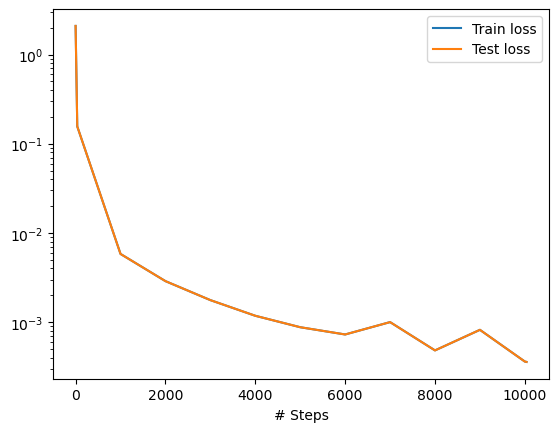

Compiling model...
'compile' took 0.000211 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
10037     [5.08e-05, 7.79e-05, 5.63e-05, 8.55e-05, 8.79e-05]    [5.08e-05, 7.79e-05, 5.63e-05, 8.55e-05, 8.79e-05]    []  
11000     [4.61e-05, 7.24e-05, 5.28e-05, 7.60e-05, 8.11e-05]    [4.61e-05, 7.24e-05, 5.28e-05, 7.60e-05, 8.11e-05]    []  
12000     [4.10e-05, 6.55e-05, 4.79e-05, 6.66e-05, 7.25e-05]    [4.10e-05, 6.55e-05, 4.79e-05, 6.66e-05, 7.25e-05]    []  
13000     [3.70e-05, 5.94e-05, 4.40e-05, 5.91e-05, 6.54e-05]    [3.70e-05, 5.94e-05, 4.40e-05, 5.91e-05, 6.54e-05]    []  
14000     [3.38e-05, 5.45e-05, 4.08e-05, 5.33e-05, 5.97e-05]    [3.38e-05, 5.45e-05, 4.08e-05, 5.33e-05, 5.97e-05]    []  
15000     [3.13e-05, 5.04e-05, 3.82e-05, 4.87e-05, 5.53e-05]    [3.13e-05, 5.04e-05, 3.82e-05, 4.87e-05, 5.53e-05]    []  
16000     [2.92e-05, 4.70e-05, 3.56e-05, 4.53e-05, 5.13e-05]    [2.

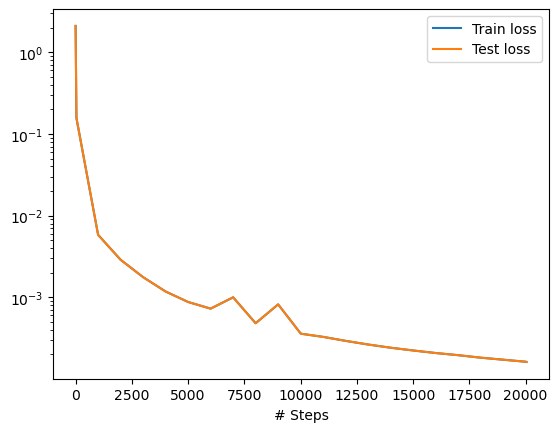

Mean residual: 0.003778444


In [8]:
# Compile, train and save model
model.compile("adam", lr=1e-3, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(
    iterations=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True
)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)
model.compile("adam", lr=1e-4, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(
    iterations=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True
)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)
# model.save(save_path = "./NS_inverse_model/model")
f = model.predict(ob_xyt, operator=Navier_Stokes_Equation)
print("Mean residual:", np.mean(np.absolute(f)))

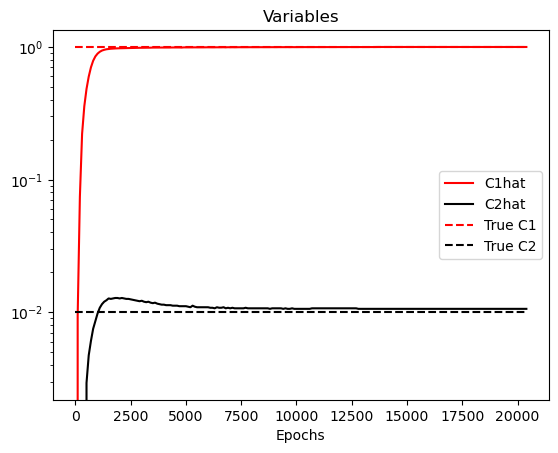

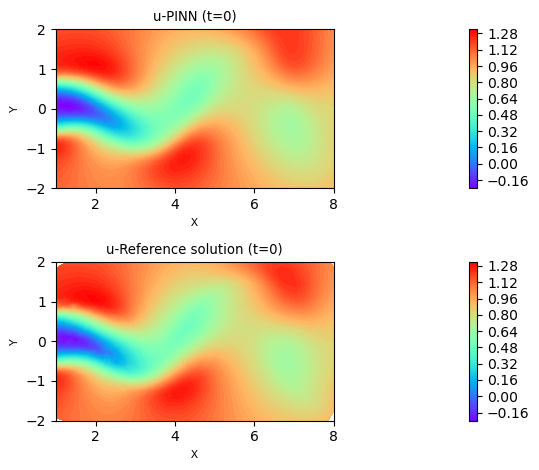

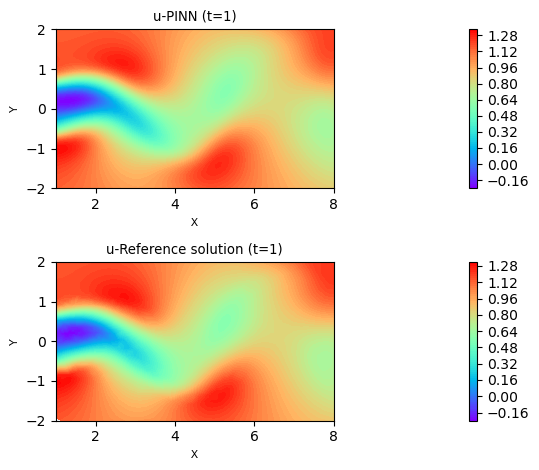

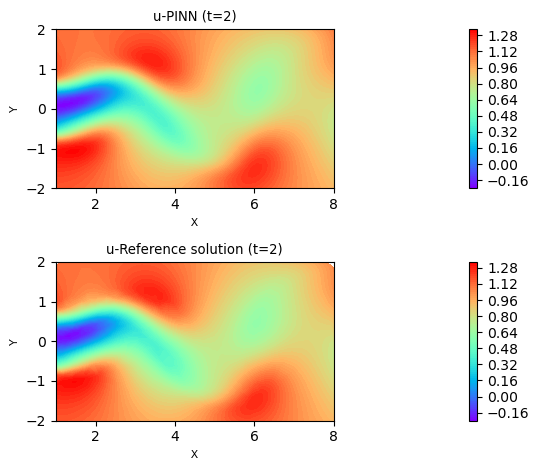

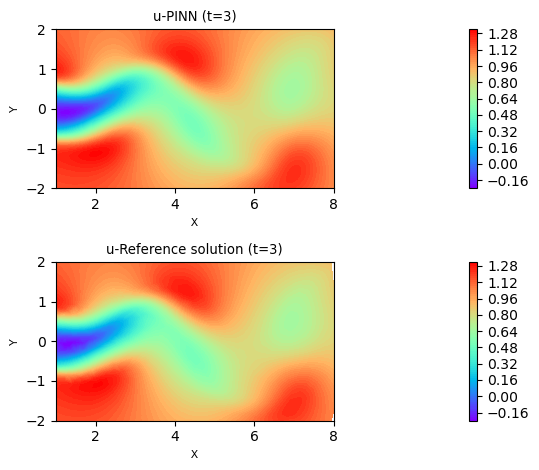

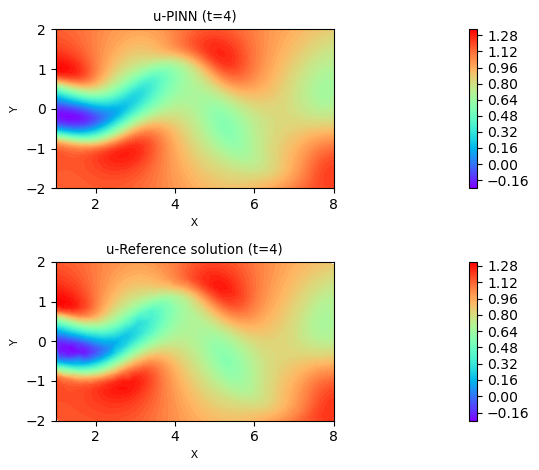

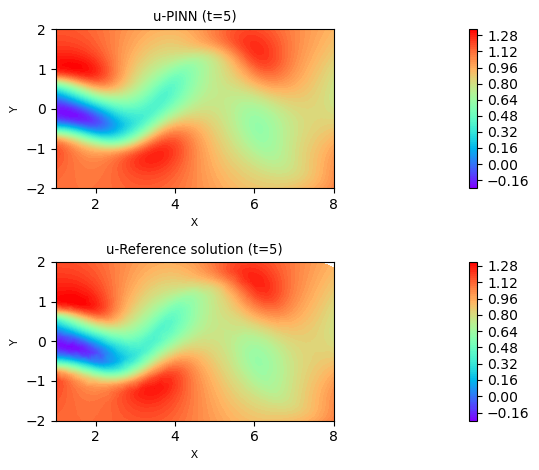

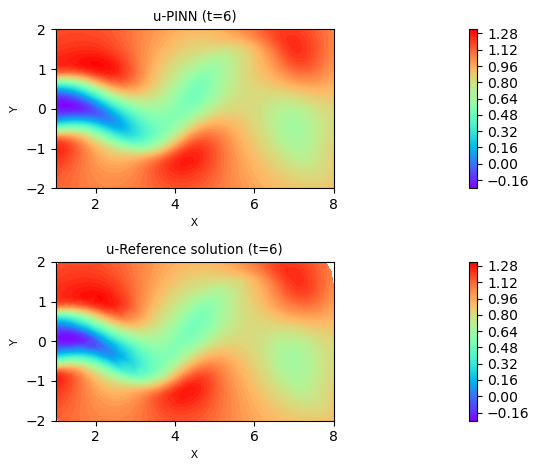

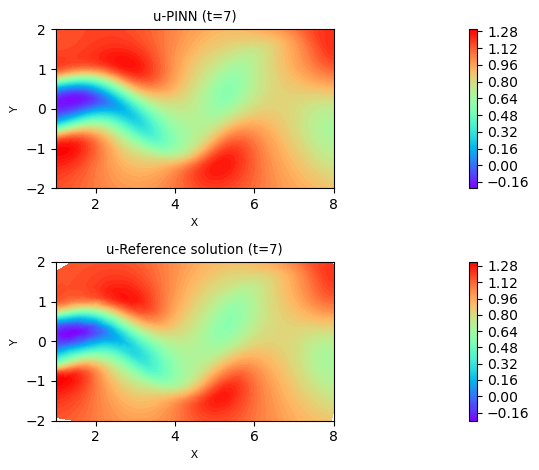

In [9]:
# Plot Variables:
# reopen saved data using callbacks in fnamevar
lines = open(fnamevar, "r").readlines()
# read output data in fnamevar
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
l, c = Chat.shape
plt.semilogy(range(0, l * 100, 100), Chat[:, 0], "r-")
plt.semilogy(range(0, l * 100, 100), Chat[:, 1], "k-")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 0].shape) * C1true, "r--")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 1].shape) * C2true, "k--")
plt.legend(["C1hat", "C2hat", "True C1", "True C2"], loc="right")
plt.xlabel("Epochs")
plt.title("Variables")
plt.show()

# Plot the velocity distribution of the flow field:
for t in range(0, 8):
    [ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=140000)
    xyt_pred = np.hstack((ob_x, ob_y, t * np.ones((len(ob_x), 1))))
    uvp_pred = model.predict(xyt_pred)
    x_pred, y_pred, t_pred = xyt_pred[:, 0], xyt_pred[:, 1], xyt_pred[:, 2]
    u_pred, v_pred, p_pred = uvp_pred[:, 0], uvp_pred[:, 1], uvp_pred[:, 2]
    x_true = ob_x[ob_t == t]
    y_true = ob_y[ob_t == t]
    u_true = ob_u[ob_t == t]
    fig, ax = plt.subplots(2, 1)
    cntr0 = ax[0].tricontourf(x_pred, y_pred, u_pred, levels=80, cmap="rainbow")
    cb0 = plt.colorbar(cntr0, ax=ax[0])
    cntr1 = ax[1].tricontourf(x_true, y_true, u_true, levels=80, cmap="rainbow")
    cb1 = plt.colorbar(cntr1, ax=ax[1])
    ax[0].set_title("u-PINN " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[0].axis("scaled")
    ax[0].set_xlabel("X", fontsize=7.5, family="Arial")
    ax[0].set_ylabel("Y", fontsize=7.5, family="Arial")
    ax[1].set_title("u-Reference solution " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[1].axis("scaled")
    ax[1].set_xlabel("X", fontsize=7.5, family="Arial")
    ax[1].set_ylabel("Y", fontsize=7.5, family="Arial")
    fig.tight_layout()
    plt.show()